In [1]:
!pip install chembl_webresource_client scanpy scperturb --quiet

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import os
import sys
from tqdm.auto import tqdm
from pathlib import Path

In [3]:
# load config
import yaml
with open('../../configuration/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
DOWNDIR = Path(config['DOWNDIR'])
TEMPDIR = Path(config['TEMPDIR'])
sys.path.insert(1, '../../')
from utils import *

In [4]:
sorted([file.name for file in (TEMPDIR / 'XuCao2023').glob('*')])

['temp']

In [5]:
from scipy.io import mmread
from scipy.sparse import csr_matrix

In [8]:
suffix = 'whole_tx'
X = csr_matrix(mmread(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}_count_matrix.mtx'))
obs = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Barcodes.tsv', index_col=0, names=['cell_barcode'])
var = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Genes.tsv', index_col=0, names=['gene_symbol'])
adata = sc.AnnData(X.T, obs, var)

In [9]:
suffix = 'nascent_tx'
X = csr_matrix(mmread(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}_count_matrix.mtx'))
obs = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Barcodes.tsv', index_col=0, names=['cell_barcode'])
var = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Genes.tsv', index_col=0, names=['gene_symbol'])
ndata = sc.AnnData(X.T, obs, var)

In [10]:
suffix = 'sgRNA'
X = csr_matrix(mmread(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}_count_matrix.mtx'))
obs = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Barcodes.tsv', index_col=0, names=['cell_barcode'])
var = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_{suffix}.Genes.tsv', index_col=0, names=['gene_symbol'])
sdata = sc.AnnData(X.T, obs, var)

In [11]:
gcounts = sdata.X.sum(1)

(array([6.8833e+04, 2.5049e+04, 3.5580e+03, 5.9100e+02, 1.5700e+02,
        6.4000e+01, 2.5000e+01, 1.6000e+01, 3.0000e+00, 9.0000e+00]),
 array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.]),
 <BarContainer object of 10 artists>)

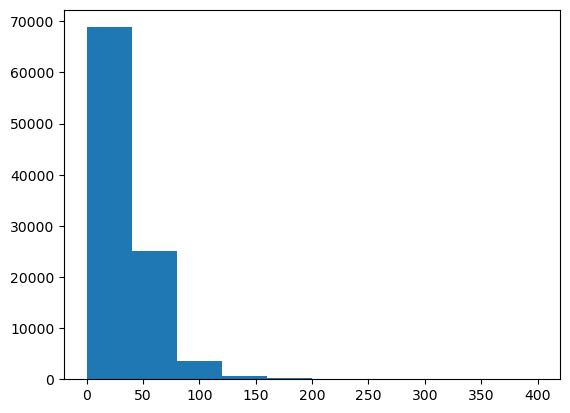

In [12]:
pl.hist(gcounts, range=(0,400))

In [13]:
# check alignment
assert all(adata.var_names==ndata.var_names)
assert all(adata.obs_names==ndata.obs_names)
assert all(adata.obs_names==sdata.obs_names)

In [22]:
adata.layers['nascent_counts'] = ndata.X.copy()
adata.obsm['sgRNA_counts'] = pd.DataFrame(sdata.X.A, index=sdata.obs_names, columns=sdata.var_names, dtype=int)
full_obs = pd.read_csv(TEMPDIR / 'XuCao2023/temp/' / f'GSM6752591_on_target_cell_metadata.csv', index_col=0)
assert all(adata.obs_names==full_obs.index)
adata.obs = full_obs.copy()

In [23]:
# harmonize metadata
adata.obs.rename({'UMI_counts': 'ncounts', 'target_genes': 'perturbation', 'target': 'guide_id'}, axis=1, inplace=True)
adata.obs.perturbation.replace('NO-TARGET', 'control', inplace=True)
cols = ['perturbation', 'ncounts', 'nascent_UMI_counts', 'nascent_ratio', 'guide_id', 'gRNA_UMI_counts', 'nascent_MT_ratio', 'Cell_cycle_phase', 'whole_exon_ratio', 'new_exon_ratio']
adata.obs = adata.obs[cols]
adata.obs['target'] = adata.obs['perturbation'].copy()

adata.obs['perturbation_type'] = 'CRISPRi'
adata.obs['disease'] = "healthy"
adata.obs['cancer'] = True
adata.obs['tissue_type']="cell_line"
adata.obs["cell_line"] = "HEK293"
adata.obs["celltype"] = 'embryonic kidney cells'
adata.obs['organism'] = 'human'
adata.obs['nperts'] = [p.count('_')+1-p.count('control') if type(p)==str else 0 for p in adata.obs.perturbation]
annotate_qc(adata, species='human')
adata.obs.index.name = 'cell_barcode'

In [24]:
assert_annotations(adata)